# Análisis de sentimiento

## 1. Importación de librerías y revisión del *dataframe*

In [40]:
import pandas as pd
import numpy as np
import re 
#from googletrans import Translator
from matplotlib import pyplot as plt
from langdetect import detect
from pysentimiento import create_analyzer
from factor_analyzer import FactorAnalyzer #librería especializada para hacer ACP
import seaborn as sns

Reviso las columnas que tengo en mi dataframe.

In [2]:
base=pd.read_csv('rawdata/clases/habitaclia5467_ejercicio2.csv')
print(base.columns.tolist())

['Unnamed: 0', 'OBJECTID', 'codigo_inmueble1', 'Title', 'Type_build', 'Type_opera', 'Link', 'Location', 'Lat_X', 'Lon_Y', 'Climatic_Z', 'Nom_Mun', 'precio_eur', 'superficie', 'superficie2', 'Unit_price', 'Ln_total_pr', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_planta', 'numero_de_piso', 'anyo_constr_ponderad', 'antig_ponderad', 'Inverse_Age', 'Year_Before_1981', 'Year_1982_2006', 'Year_After_2007', 'superficie_terraza_m2', 'grand_terr_20m2', 'superficie_jardin_m2', 'superficie_salon', 'bool_despacho', 'bool_buhardilla', 'bool_trastero', 'bool_lavadero', 'bool_piscina_comunitaria', 'bool_jardin_comunitario', 'bool_amueblado', 'bool_ascensor', 'descripcion', 'bool_aire_acondicionado', 'bool_calefaccion', 'bool_chimenea', 'texto_destacado', 'Description', 'calificacion_consumo_letra', 'calificacion_consumo_valor', 'calificacion_emision_letra', 'calificacion_emision_valor', 'Dum_EPC', 'EPC_A_emision', 'EPC_B_emision', 'EPC_C_e

Con `Ctrl+F` puedo ver que hay dos que podrían tener la descripción de los anuncios. Las reviso.

In [3]:
base[['Description','descripcion']].head()

,Description,descripcion
0,"Piso reformado de 4 habitaciones, salón comedo...",NaN
1,"BENET MATEU, PIS D´ORIGEN AMB MOLT BONA DISTRI...",NaN
2,Apartamento pero con acceso independiente desd...,conservada
3,"[A2977]PISAZO, EL MEJOR DE LA ZONA.FENOMENAL P...",reformada
4,[A3001]VIVIENDA EN LA CALLE GARROFER DE SANT I...,reformada


In [8]:
len(base)

5467

## 2. Limpieza de `Description`

Paso a limpiar el texto. Defino una serie de funciones.

In [4]:
def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text

def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

def filter_ibans(text):
    pattern = r'ES\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|ES\d{20}|ES[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text

def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text

def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text

def filter_ref(text):
    pattern = r'(\(*)(ref|REF)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text

def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text

def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text

def remove_large_numbers(text):
    pattern = r'\b\d{4,}\b'
    text = re.sub(pattern, '', text)
    return text

def remove_text_in_brackets(text):
    pattern = r'\[[^\]]*\]|\{[^}]*\}'
    text = re.sub(pattern, '', text)
    return text

Ahora agrupo todas esas funciones y las aplico a `base` para crear una nueva columna.

In [5]:
def clean_text(text):
    if isinstance(text, str):  # Verifica si text es una cadena de texto
        text = text.replace(u'\xa0', u' ')
        text = treat_m2(text)
        text = treat_euro(text)
        text = filter_phone_numbers(text)
        text = filter_emails(text)
        text = filter_ibans(text)
        text = filter_ref(text)
        text = filter_websites(text)
        text = remove_space_between_numbers(text)
        text = remove_large_numbers(text)
        text = remove_text_in_brackets(text)
    return text

base['cl_descrip'] = base.Description.apply(clean_text)
base['cl_descrip'].head()

0    Piso reformado de 4 habitaciones, salón comedo...
1    BENET MATEU, PIS D´ORIGEN AMB MOLT BONA DISTRI...
2    Apartamento pero con acceso independiente desd...
3    PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...
4    VIVIENDA EN LA CALLE GARROFER DE SANT IDELFONS...
Name: cl_descrip, dtype: object

Tenemos un problema más: **¡Hay texto en catalán!** Y probablemente en algún otro idioma, dado que algunos anuncios los ponen en distintos idiomas a la vez.

## 3. Corte de la descripción y traducción al español

Debido al tamaño de nuestro dataframe, es probable que convenga cortar la cantidad de palabras por celda.

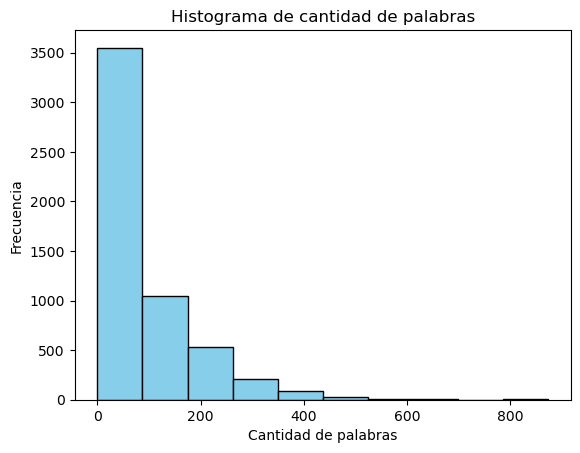

In [30]:
# Dividir cada elemento de la columna 'Description' en palabras y contar la cantidad de palabras
base['cantidad_palabras'] = base['cl_descrip'].apply(lambda x: len(x.split()))

# Crear un histograma de la cantidad de palabras
plt.hist(base['cantidad_palabras'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de palabras')
plt.show()

Creo que un número entre 300 y 400 podría ser más que suficiente. Empiezo creando una columna que me indique el idioma en el que está cada fila con la función `detect` de `langdetect`.

In [11]:
# Función para detectar el idioma de un texto
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Suponiendo que `df` es tu DataFrame y 'Description' es la columna con los textos
# Agrega una nueva columna 'Language' con el idioma detectado para cada descripción
base['Language'] = base['cl_descrip'].apply(detect_language)

In [33]:
base['Language'].head()

0    es
1    de
2    es
3    de
4    en
Name: Language, dtype: object

Los resultados no parecen ser tan buenos, pues reconoce el catalán como alemán, y en algunos casos, el mismo español como alemán.
Sin embargo, esto no debería ser un gran problema: si a continuación le pido que todas aquellas filas con un idioma distinto al español (`!= 'es'`) sean traducidas a ese idioma, aquellas que ya estén en español no sufrirán mayores cambios.

In [32]:
#En caso haya alguna celda en blanco, la relleno con un espacio en blanco
base['cl_descrip'] = base['cl_descrip'].fillna('')

# Función para cortar el texto a un máximo de 300 palabras
def truncate_text(text):
    words = text.split()[:300]
    truncated_text = ' '.join(words)
    return truncated_text

# Aplico la función para truncar el texto en la columna 'cl_descrip'
base['cl_descrip'] = base['cl_descrip'].apply(truncate_text)

# Filtro las filas que tienen 'Language' algo distinto al español ('es')
no_esp_descriptions = base[base['Language'] != 'es']['cl_descrip']

# Traduzco las descripciones al español
translated_descriptions = []
for description in no_esp_descriptions:
    translated_description = GoogleTranslator(source='auto', target='es').translate(description)
    translated_descriptions.append(translated_description)

# Reemplazo las descripciones traducidas en el DataFrame original
base.loc[base['Language'] != 'es', 'cl_descrip'] = translated_descriptions

base['cl_descrip'].head()

0    Piso reformado de 4 habitaciones, salón comedo...
1    BENET MATEU, PISO DE ORIGEN CON MUY BUENA DIST...
2    Apartamento pero con acceso independiente desd...
3    PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...
4    VIVIENDA EN LA CALLE GARROFER DE SANT IDELFONS...
Name: cl_descrip, dtype: object

In [35]:
base['cl_descrip'].tail()

5462    Piso En Mollet Del Vallès!Ubicado a 600m de la...
5463    La Casa Agency presenta en Exclusividad, esta ...
5464    Mis Finques promociona esta planta baja con pa...
5465    PISO CON TERRAZAPiso con TERRAZA DE 40M2. La v...
5466    Precioso piso en una finca joven de tan solo 1...
Name: cl_descrip, dtype: object

Ahora que ya lo tengo en español, hago el análisis de sentimiento.

In [36]:
# Crear el analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Suponiendo que tienes un DataFrame llamado df con una columna 'Description'
# Aplicar el análisis de sentimientos a todas las filas de la columna 'Description'
sentiments = base['cl_descrip'].apply(analyzer.predict)

# Extraer los valores de probabilidad para cada categoría y crear las nuevas columnas
base['POS'] = [result.probas.get('POS', 0) for result in sentiments]
base['NEU'] = [result.probas.get('NEU', 0) for result in sentiments]
base['NEG'] = [result.probas.get('NEG', 0) for result in sentiments]

In [37]:
base[['cl_descrip','POS','NEU','NEG']].head()

,cl_descrip,POS,NEU,NEG
0,"Piso reformado de 4 habitaciones, salón comedo...",0.634861,0.352537,0.012602
1,"BENET MATEU, PISO DE ORIGEN CON MUY BUENA DIST...",0.736040,0.250749,0.013210
2,Apartamento pero con acceso independiente desd...,0.788073,0.200277,0.011651
3,"PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...",0.965982,0.029098,0.004920
4,VIVIENDA EN LA CALLE GARROFER DE SANT IDELFONS...,0.405443,0.552446,0.042112


En este momento, recomiendo abrir el documento en Excel y ver qué tal ha quedado y si hay algo que se nos esté pasando.

In [ ]:
base.to_excel('rawdata/clases/pruebasentiment.xlsx')

Lo que me encuentro es que hay celdas con descripción vacía (`cantidad_palabras`=0), pero en donde se han ponderado los sentimientos. Creo que es algo que deberíamos mejorar. 

Me parece que aquellas que no tienen descripción es porque deberían tener un sentimiento negativo asociado, pero no deberían tener nada de positivo ni de neutral. Si fuese así, ¿qué valor `NEG` le deberíamos poner? Podría ser el valor promedio, siempre que la distribución de la variable sea normal. Empecemos revisando eso.

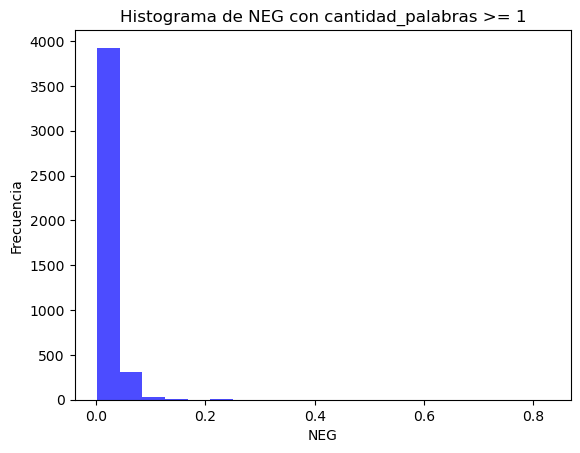

In [50]:
# Filtra el DataFrame para incluir solo las filas donde 'cantidad_palabras' es mayor o igual que 1
filtered_df = base[base['cantidad_palabras'] >= 1]

# Crea el histograma de la columna 'NEG' en el DataFrame filtrado
plt.hist(filtered_df['NEG'], bins=20, color='blue', alpha=0.7)
plt.xlabel('NEG')
plt.ylabel('Frecuencia')
plt.title('Histograma de NEG con cantidad_palabras >= 1')
plt.show()

Como no es una distribución normal, usar el promedio no capturaría la distribución de los datos. En esos casos, es preferible usar la mediana: el valor que está justo en el centro de los datos.

In [52]:
#Obtengo la mediana
median_neg = filtered_df['NEG'].median()

# Función para actualizar 'POS', 'NEU' y 'NEG' cuando la cantidad de palabras es igual a 0
def update_sentiment_values(row):
    if row['cantidad_palabras'] == 0:
        row['POS'] = 0
        row['NEU'] = 0
        row['NEG'] = median_neg
    return row

# Aplica la función a cada fila del DataFrame
prueba = base.apply(update_sentiment_values, axis=1)

# Guarda el DataFrame modificado en un archivo Excel
prueba.to_excel('rawdata/pruebasentiment.xlsx')

## 4. Análisis de Componentes Principales

Con el análisis hecho, notamos que tenemos tres nuevas variables. Podríamos intentar hacer un ACP para ver si es posible tener una sola variable que las sintetice.

In [53]:
#Le indicamos en qué columnas se va a centrar
df = base[['POS','NEU','NEG']]

#Le pedimos un ACP con rotación varimax y N factores
fa = FactorAnalyzer(rotation='varimax', n_factors=3, #esto lo indican ustedes, deben ir probanod 
                    method='principal')
fa.fit(df)

# Obtener la varianza total explicada
total_variance = fa.get_factor_variance()

# Crear un DataFrame para mostrar la tabla de la varianza total explicada
explained_variance_df = pd.DataFrame(total_variance, columns=['Factor1', 'Factor2',
                                                             'Factor3'], #Deben aumentar o disminuir según la 
                                                                         #cantidad de factores que hayan indicado
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

#Esto es solo para que la tabla se vea mejor
explained_variance_df = explained_variance_df.transpose()

print("Tabla de Varianza Total Explicada:")
print(explained_variance_df)

Tabla de Varianza Total Explicada:
          SS Loadings  Proportion Var  Cumulative Var
Factor1  1.923330e+00    6.411101e-01         0.64111
Factor2  1.076670e+00    3.588899e-01         1.00000
Factor3  1.760636e-14    5.868786e-15         1.00000


Noto que a partir del segundo factor ya explico un 100% de las tres variables. Tratemos de interpretarlos.

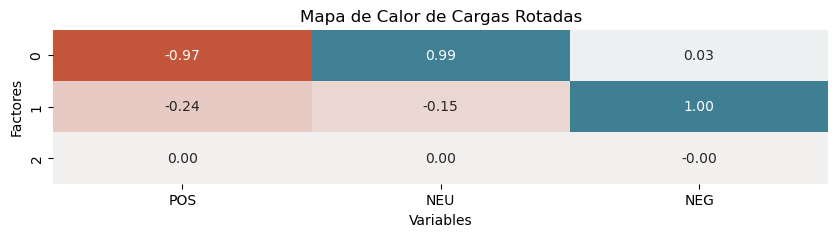

In [54]:
rotated_loadings = fa.loadings_

# Transponer la matriz de cargas rotadas para que las columnas coincidan con las variables
rotated_loadings_transposed = rotated_loadings.T

rotated_df = pd.DataFrame(rotated_loadings_transposed, columns=df.columns)

# Definir los colores para el mapa de calor
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Crear el mapa de calor
plt.figure(figsize=(10, 2)) #Altura y ancho, lo pueden variar
sns.heatmap(rotated_df, cmap=cmap, annot=True, fmt=".2f", cbar=False, vmin=rotated_df.min().min(), vmax=rotated_df.max().max())
plt.title('Mapa de Calor de Cargas Rotadas')
plt.xlabel('Variables')
plt.ylabel('Factores')
plt.show()

El primer factor (`0`) es totalmente neutral y para nada positivo. Mientras que el segundo (`1`), es totalmente negativo.

In [55]:
# Obtener los factores extraídos
factors = fa.transform(df)

# Agregar los factores al DataFrame original
base['Sent_NEU_noPOS'] = factors[:, 0] #Este es el número que me interesa
base['Sent_NEG'] = factors[:, 1] #Este es el número que me interesa

In [56]:
base.to_csv('rawdata/clases/habitaclia5467_ejercicio3.csv')